# Function Goal

This Notebook aims to cluster activites of providers


In [1]:
import sys
print(sys.version)
print(sys.executable)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
/opt/anaconda3/bin/python


# Imports

In [2]:
# import classic libraries
# ------------------------
import pandas as pd
import sys
import os
import pickle
import re
from importlib import reload
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import coo_matrix, hstack

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as TSNE_scikit
# pd.set_option('max_colwidth', 86)

In [3]:
# import custom library
# ------------------------
import os
current_path = os.path.abspath(os.getcwd())
path_lib = current_path.replace('src','')
path_data = current_path.replace('src','data')
sys.path.append(path_lib)

import lib_ar_src
reload(lib_ar_src)
print(lib_ar_src.__version__)

1.0.0


In [4]:
from lib_ar_src.utils.io_utils import importData
from lib_ar_src.clustering.display import plotClusterExample
from lib_ar_src.clustering.display import printCluster
from lib_ar_src.clustering.display import printClusterDistribution
from lib_ar_src.clustering.display import printClusterHomogeneityDistribution
from lib_ar_src.clustering.display import plotClusters
from lib_ar_src.clustering.display import plot_heatmap_dbscan
from lib_ar_src.clustering.display import plot_homog_hdbscan
from lib_ar_src.clustering.display import print_biggestClusters

# Function definition

In [5]:
def html2text(html):
    """
    Remove html tags
    """
    from bs4 import BeautifulSoup
    try:
        soup = BeautifulSoup(html)
        text = soup.get_text()
    except:
        text = html
        
    return text

def intConverter(x):
    ''' robust cast to int '''
    out = -1
    try:
        out = int(x)
    except:
        print('error nan?')
    return out

def floatConverter(x):
    ''' robust cast to int '''
    out = -1
    try:
        out = float(x)
    except:
        print('error nan?')
    return out


def prepare_data_4_clustering(X, df, dict_weight={}, bool_PCA=False, bool_standardization=False):
    """
    preprocess data for clustering
    - normalization by min max
    - PCE (eventual)
    - standardization (eventual)
    """
    
    from sklearn import preprocessing
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    # Normalisation - scaling
    # -----------------------
    scaler = preprocessing.MinMaxScaler().fit(X) # nb with_mean=False obligatoire pour sparse matrix
    Xnorm_raw = scaler.transform(X)
    plt.figure(figsize=(10,10))
    sns.heatmap(Xnorm_raw)
    plt.title('data after scaling')

    # Weighting
    # --------
    list_weights = [] 
    for col in df: # for each column
        default_weight = 1
        for key in dict_weight: # test if belonging to a category
            if (col.find(key) != -1): # if yes
                default_weight = dict_weight[key] # retrieve the appropriate weight
        list_weights.append(default_weight) # append the weight

    Xnorm_weighted = Xnorm_raw
    for col in range(Xnorm_weighted.shape[1]):
        Xnorm_weighted[:,col] = list_weights[col]*Xnorm_weighted[:,col]
    plt.figure(figsize=(10,10))
    sns.heatmap(Xnorm_weighted)
    plt.title('data after weighting')

    # PCA (to keep size under control)
    # ---------------------------------
    if bool_PCA:
        pca = PCA(n_components=100)
        Xnorm = pca.fit_transform(Xnorm_weighted) # conversion from sparse to array is necessary
        print('total explained variance of PCA is : ', sum(pca.explained_variance_ratio_))
        plt.figure(figsize=(10,10))
        sns.heatmap(abs(Xnorm))
        plt.title('data after PCA')
    else:
        Xnorm = Xnorm_weighted


    # Data standardization (eventual)
    # ------------------------------
    if bool_standardization:
        scaler = preprocessing.StandardScaler().fit(Xnorm ) # nb with_mean=False obligatoire pour sparse matrix
        X_total_scaled = scaler.transform(Xnorm)

        plt.figure(figsize=(10,10))
        sns.heatmap(X_total_scaled)
    else:
        X_total_scaled = Xnorm

    # Data used for fitting
    # ---------------------
    x_data = X_total_scaled
    
    return x_data

def create_corpus_from_text_columns(df, col_list):
    """ create a corpus for BAG of word, from specified columns of a df """
    corpus = ''
    for ir in range(df.shape[0]):
        for col in col_list:
            elem = df.loc[ir,col]
            corpus += ' '
            corpus += str(elem)

    # corpus_cleaned
    from lib_ar_src.utils.text_utils import clean_text
    corpus_cleaned = clean_text(corpus)
    corpus_cleaned = re.sub('[0-9]', '', corpus_cleaned)

    return corpus_cleaned

def create_bow(corpus, maxF=100):
    '''
    Create bow model
    '''
    from sklearn.feature_extraction.text import CountVectorizer 
    
    try: # create a list of french and english stopwords
        from nltk.corpus import stopwords    
        final_stopwords_list = stopwords.words('english') \
        + stopwords.words('french') \
        + stopwords.words('german') \
        + stopwords.words('italian')
        
    except:  # if first time, download stopwords list
        import nltk
        nltk.download('stopwords')
        from nltk.corpus import stopwords    
        final_stopwords_list = stopwords.words('english') \
        + stopwords.words('french') \
        + stopwords.words('german') \
        + stopwords.words('italian') 
        
    # create the model
    vectorizer = CountVectorizer(
        max_features=maxF,
        analyzer = 'word',
        stop_words=final_stopwords_list
    )
    bow = vectorizer.fit_transform(corpus)

    return bow, vectorizer


def enrich_with_bow(df, column_name, vectorizer):
    '''
    Enrich a dataframe with bow model applied on a column
    Adds new columns with counts of most common words
    '''
    df_enriched = df.copy()    
    df_bow_mat = vectorizer.transform(df[column_name])
    feature_names = vectorizer.get_feature_names()
    feature_names_formatted = ['bow_'+column_name+'_'+f for f in feature_names]
    df_bow = pd.DataFrame(df_bow_mat.toarray(), columns=feature_names_formatted)   
    df_enriched = pd.concat([df_enriched, df_bow], axis=1)
   
    return df_enriched


def replace_cols_with_bow(df, list_cols_bow, maxF=50):
    """" Replace specified columns by bow  """
    
    df_bow = df.copy()
    
    # force string format
    for col in list_cols_bow:
        df_bow[col] = df_bow[col].apply(lambda x : str(x))
    
    # create a corpus to train BOW    
    corpus_cleaned = create_corpus_from_text_columns(df_bow, list_cols_bow)

    # create bow features
    bow, vectorizer = create_bow([corpus_cleaned], maxF=maxF)
    print('vocabulary used for bow is : ', vectorizer.vocabulary_)

    # add bow features
    for col in list_cols_bow:
        df_bow = enrich_with_bow(df_bow, col, vectorizer)

    # remove textual columns
    from lib_ar_src.utils.df_utils import drop_columns
    df_bow = drop_columns(df_bow, list_cols_bow)
    
    return df_bow

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }   div.cell.selected {border-left-width: 1px !important;} </style>"))

# Import data

In [7]:
!ls ../data

dates.json
events activities.json
extract BK data per location activities.xlsx
extract BK data per location vendors.xlsx
extract BK data per location.xlsx
products.json
vendors.json


In [8]:
# fake or incomplete data
# -----------------------
# df_fake_dates_raw   = importData(os.path.join(path_data, 'dates.json'), 10000)
# df_fake_events_raw   = importData(os.path.join(path_data, 'events activities.json'), 10000)
# df_fake_products_raw   = importData(os.path.join(path_data, 'products.json'), 10000)
# df_fake_vendors_raw   = importData(os.path.join(path_data, 'vendors.json'), 10000)

# complete data (coming from firestore)
# -------------------------------------
df_activities_raw   = importData(os.path.join(path_data, 'extract BK data per location activities.xlsx'), 10000)
df_vendors_raw   = importData(os.path.join(path_data, 'extract BK data per location vendors.xlsx'), 10000)


number of samples : 2354


,id,active,root_event_id,title,description,type,duration,pre_time,max_participants,location,...,images/42,images/43,images/44,tags/3/values/2,tags/3/values/3,country_of_residence,address_pos,city_pos,country_pos,city
0,f9d00ddbf493f6ff340cd77d37660f7a,1,NaN,BRAVO SPORT Fußballcamps - SV 1922 Zwiesel 28....,"<p>Zu cool, um wahr zu sein? Von wegen! Die BR...",BOOKING,720.0,0.0,20,"Rotwaldsiedlung 13, 94227 Zwiesel, Deutschland",...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,34.0,NaN,94227 Zwiesel
1,691d5a6b83ab3aff8561ba691621b97a,1,NaN,ONLINE ESCAPE GAME: AUSGANGSSPERRE,<p><strong>Wir bringen Euch den R&auml;tselspa...,BOOKING,120.0,0.0,1000,@HOME,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,@HOME


number of samples : 191


,id,name,url,service_email,service_phone,image,terms,bill_country,country_of_residence,activation_date
0,4379934535e774c3a53b956677f92c0e,Azienda Agricola Bocale di Valentini,https://www.bocale.wine/,info@bocale.it,+390742399233,https://cdn.bookingkit.de/vendor_images/f7a2b2...,<p>In merito alla nostra politica di cancellaz...,IT,IT,2021-01-11T14:55:37Z
1,fe595f13d6bc9618c45f6c3dfc73fd71,Stadtführungen Kassel,https://www.stadtfuehrungen-kassel.de,panetta-moeller@t-online.de,+4956167994,https://cdn.bookingkit.de/vendor_images/934d57...,<p><br />Allgemeine Gesch&auml;ftsbedingungen<...,DE,DE,2021-01-11T14:55:36Z


# Clean data

In [9]:
# for col in df_activities_raw:
#     print(col)

In [10]:
df_activities_clean = df_activities_raw.copy()
df_vendors_clean =  df_vendors_raw.copy()

# clean html into text for activities
html_columns = ['bring', 'advice', 'hint', 'participant_hint', 'title', 'terms', 'description']
# 
for col in html_columns:
    if col in df_activities_clean:
        df_activities_clean[col] = df_activities_clean[col].apply(lambda x : html2text(x))
    if col in df_vendors_clean:
        df_vendors_clean[col] = df_vendors_clean[col].apply(lambda x : html2text(x))

# Merge data

In [11]:
# Display available columns
# -------------------------
# for col in df_activities_raw:
#     print(col)

In [12]:
# merge on vendor id
df_merge = pd.merge(df_activities_clean, df_vendors_clean, left_on=['vendor_id'], right_on = 'id', how='left')
print(df_merge.shape[0])
df_merge = df_merge.fillna(-1)
df_merge=df_merge[df_merge["country_of_residence_y"]=='DE']
df_merge

2354


,id_x,active,root_event_id,title,description,type,duration,pre_time,max_participants,location,...,id_y,name,url,service_email,service_phone,image,terms,bill_country,country_of_residence_y,activation_date
0,f9d00ddbf493f6ff340cd77d37660f7a,1,-1,BRAVO SPORT Fußballcamps - SV 1922 Zwiesel 28....,"Zu cool, um wahr zu sein? Von wegen! Die BRAVO...",BOOKING,720.0,0.0,20,"Rotwaldsiedlung 13, 94227 Zwiesel, Deutschland",...,3b8bcc9344179bdfff454eaadbf03684,erlebnis-buchen.com,erlebnis-buchen.com,noreply@bookingkit.de,030609850332,https://cdn.bookingkit.de/vendor_images/edc56c...,<p>AGB der Demo Inc.</p>,DE,DE,2021-01-06T12:28:50Z
1,691d5a6b83ab3aff8561ba691621b97a,1,-1,ONLINE ESCAPE GAME: AUSGANGSSPERRE,Wir bringen Euch den Rätselspaß nach Hause!\n ...,BOOKING,120.0,0.0,1000,@HOME,...,8c5f7b595bd74eeb915ffa1ae647463a,Dresden Secrets - Escape Games & iPad Rallyes,www.dresden-secrets.de,info@cbikes.de,+4935165318888,https://cdn.bookingkit.de/vendor_images/27b7dc...,"1. Vertragsinhalt Dresden Secrets, Markus Brac...",DE,DE,2021-01-11T14:54:51Z
2,729a82be1e45148c699794fdffefe954,1,-1,ONLINE ESCAPE GAME: LOST CHRISTMAS,Wir bringen Euch den Rätselspaß nach Hause!\nK...,BOOKING,120.0,0.0,1000,@HOME,...,8c5f7b595bd74eeb915ffa1ae647463a,Dresden Secrets - Escape Games & iPad Rallyes,www.dresden-secrets.de,info@cbikes.de,+4935165318888,https://cdn.bookingkit.de/vendor_images/27b7dc...,"1. Vertragsinhalt Dresden Secrets, Markus Brac...",DE,DE,2021-01-11T14:54:51Z
3,c4488666ffceb5de00ec524a45678725,1,-1,Gutschein,"Ob zum Geburtstag, zu Weihnachten, zur Hochzei...",BOOKING,0.0,0.0,1,"Theodor-Heuss-Straße 32, 70174 Stuttgart, Deut...",...,c04d4dcf8618d01cb3ad1c01d5d34e7b,ExitGames Stuttgart,www.exitgames-stuttgart.de,info@exitgames-stuttgart.de,(+49) 0711/18424240,https://cdn.bookingkit.de/vendor_images/bf573f...,AGB,DE,DE,2021-01-11T14:54:25Z
4,98a16d521d47c2f8f09908610fcabd6f,1,-1,ONLINE ESCAPE GAME: DIAMANTENFIEBER,Wir bringen Euch den Rätselspaß nach Hause!\nK...,BOOKING,120.0,0.0,1000,@HOME,...,8c5f7b595bd74eeb915ffa1ae647463a,Dresden Secrets - Escape Games & iPad Rallyes,www.dresden-secrets.de,info@cbikes.de,+4935165318888,https://cdn.bookingkit.de/vendor_images/27b7dc...,"1. Vertragsinhalt Dresden Secrets, Markus Brac...",DE,DE,2021-01-11T14:54:51Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,8335bdc9973ef26681923f632b1b171c,1,-1,Mentoren Training,Lassen Sie sich zum Mentoren Spezialisten ausb...,BOOKING,4320.0,15.0,5,"Hof, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE,DE,2021-01-11T14:55:36Z
2331,55290f6cecd9129b47d15f57c0cc28e2,1,-1,Live Seminar zum Thema - Erfolgreicher Vertrie...,In 4 ausgewählten und erfolgsorientierten Modu...,BOOKING,180.0,600.0,10,"Berlin, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE,DE,2021-01-11T14:55:36Z
2332,596beda6badc3e62973bfa2f762c827c,1,-1,Live Seminar zum Thema - Erfolgreicher Vertrie...,In 4 ausgewählten und erfolgsorientierten Modu...,BOOKING,180.0,600.0,10,"Berlin, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE,DE,2021-01-11T14:55:36Z
2333,858e3a3137fc7b4ad1fa967fafd8dd2e,1,-1,Live Seminar zum Thema - Erfolgreicher Vertrie...,In 4 ausgewählten und erfolgsorientierten Modu...,BOOKING,180.0,600.0,10,"Berlin, Deutschland",...,4cb7bc2b927ffc1018c491dfc34071e7,Prealize GmbH,www.prealize.de,cornelia.jeschek@prealize.de,+491715320755,https://cdn.bookingkit.de/vendor_images/b8543b...,Allgemeine Geschäftsbedingungen (AGB) \nfür On...,DE

# Remarks and insights
- will all those fiels be available with other datasets
- duplicates event id? or because of merge?
- what is pretime?

Features useful :
- title
- location (adress, lon, lat, meeting location)
- adress pos / city pos / country pos
- name or url or service email or phone
- description
- vendor id
- vendor name
- categories/i/title or id

maybe useful
- duration
- bring
- advice
- hint
- participant hint
- highlights/0
- prices




# Encoding

In [13]:
df_merge['description']

0       Zu cool, um wahr zu sein? Von wegen! Die BRAVO...
1       Wir bringen Euch den Rätselspaß nach Hause!\n ...
2       Wir bringen Euch den Rätselspaß nach Hause!\nK...
3       Ob zum Geburtstag, zu Weihnachten, zur Hochzei...
4       Wir bringen Euch den Rätselspaß nach Hause!\nK...
                              ...                        
2330    Lassen Sie sich zum Mentoren Spezialisten ausb...
2331    In 4 ausgewählten und erfolgsorientierten Modu...
2332    In 4 ausgewählten und erfolgsorientierten Modu...
2333    In 4 ausgewählten und erfolgsorientierten Modu...
2334    In 4 ausgewählten und erfolgsorientierten Modu...
Name: description, Length: 1638, dtype: object

In [14]:
# Load the regular expression library
import re

# Remove punctuation
df_merge['description_processed'] = \
df_merge['description'].map(lambda x: re.sub('[,\.!?\n]', '', str(x)))

# Convert the titles to lowercase
df_merge['description_processed'] = \
df_merge['description_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df_merge['description_processed'].head()

0    zu cool um wahr zu sein von wegen die bravo sp...
1    wir bringen euch den rätselspaß nach hause kli...
2    wir bringen euch den rätselspaß nach hauseklic...
3    ob zum geburtstag zu weihnachten zur hochzeit ...
4    wir bringen euch den rätselspaß nach hauseklic...
Name: description_processed, dtype: object

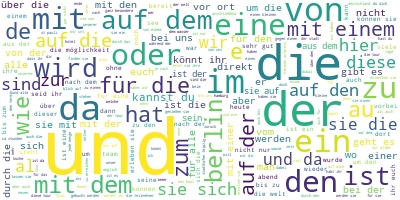

In [15]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_merge['description_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


german_stop_words = stopwords.words('german')

vect = CountVectorizer(stop_words = german_stop_words) # Now use this in your pipeline

In [17]:
def stop_word_removal(x):
    token = x.split()
    return ' '.join([w for w in token if not w in german_stop_words])


df_merge['description_processed_stop_word']  = df_merge['description_processed'].apply(stop_word_removal)

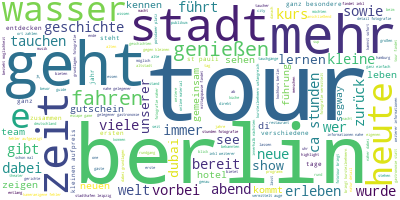

In [18]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_merge['description_processed_stop_word'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Prepare text for LDA analysis 

### Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionar

In [27]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('german')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','the','of','and','naturlich'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = df_merge.description_processed_stop_word.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/idriouich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['cool', 'wahr', 'wegen', 'bravo', 'sport', 'fußballcamps', 'bieten', 'per', 'superstars', 'fußballs', 'hochste', 'zeit', 'know', 'how', 'weiterzugeben', 'trainieren', 'profis', 'lautet', 'motto', 'gibt', 'fun', 'ende', 'fußball', 'ja', 'schließlich', 'spaß', 'verbinden', 'mega', 'fun', 'profi']


In [28]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View

print(corpus[:1][0][:30])


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


## LDA model tranining 

In [29]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"kannst" + 0.008*"schon" + 0.008*"kurs" + 0.007*"konnt" + '
  '0.007*"wetter" + 0.007*"wasser" + 0.007*"mal" + 0.006*"immer" + '
  '0.006*"boot" + 0.006*"online"'),
 (1,
  '0.016*"tour" + 0.007*"stadthafen" + 0.006*"gut" + 0.006*"leipzig" + '
  '0.005*"kleinen" + 0.004*"bitte" + 0.004*"leipziger" + 0.004*"erreichen" + '
  '0.004*"inkl" + 0.004*"verleih"'),
 (2,
  '0.012*"massage" + 0.003*"thai" + 0.003*"zeit" + 0.003*"minuten" + '
  '0.003*"ratsel" + 0.003*"ol" + 0.003*"berlin" + 0.003*"welt" + 0.003*"seit" '
  '+ 0.002*"up"'),
 (3,
  '0.004*"gutschein" + 0.003*"stunde" + 0.003*"ganz" + 0.003*"stunden" + '
  '0.003*"kurs" + 0.003*"wasser" + 0.003*"beachten" + 0.003*"sup" + '
  '0.003*"faq" + 0.003*"areale"'),
 (4,
  '0.005*"comedy" + 0.004*"show" + 0.004*"seminar" + 0.004*"berlin" + '
  '0.003*"abend" + 0.003*"erleben" + 0.003*"berliner" + 0.003*"se" + '
  '0.003*"live" + 0.003*"spaß"'),
 (5,
  '0.009*"to" + 0.005*"you" + 0.005*"fotografie" + 0.004*"tour" + '
  '0.004*"ai

### Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:


### Better understanding and interpreting individual topics, and
### Better understanding the relationships between the topics.

### For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

### For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [30]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


###

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
LDAvis_prepared

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.304519 -0.001720       1        1  21.118017
6      0.084010  0.165229       2        1  18.168280
1      0.045098  0.086831       3        1  13.091102
4      0.056613  0.050536       4        1  12.685969
5      0.073541 -0.196308       5        1  12.383863
3     -0.041223 -0.017997       6        1  12.049139
2      0.086481 -0.086571       7        1  10.503630, topic_info=           Term        Freq       Total Category  logprob  loglift
966      kannst  325.000000  325.000000  Default  30.0000  30.0000
23005     dubai  221.000000  221.000000  Default  29.0000  29.0000
5002    massage  147.000000  147.000000  Default  28.0000  28.0000
288        tour  546.000000  546.000000  Default  27.0000  27.0000
1746         to  147.000000  147.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
243    genießen   21.979835  173.635666   Topic7  -6.3305   0.1866
423       macht   20.219247   97.252466   Topic7  -6.4139   0.6828
540        mehr   20.975494  173.598195   Topic7  -6.3772   0.1401
1916      stadt   19.534204  148.794932   Topic7  -6.4484   0.2230
151       dabei   19.196265  195.906617   Topic7  -6.4659  -0.0695

[470 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
594       1  0.203664    ab
594       2  0.186207    ab
594       3  0.168750    ab
594       4  0.093104    ab
594       5  0.133837    ab
...     ...       ...   ...
110       2  0.080132  zwei
110       3  0.092460  zwei
110       4  0.154100  zwei
110       6  0.036984  zwei
110       7  0.024656  zwei

[979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 2, 5, 6, 4, 3])

In [26]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


LDAvis_prepared
###

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.008*"boot" + 0.006*"aufpreis" + 0.005*"ganz" + 0.005*"mehr" + '
  '0.005*"schon" + 0.005*"st" + 0.004*"pauli" + 0.004*"dabei" + 0.004*"immer" '
  '+ 0.004*"ol"'),
 (1,
  '0.011*"tour" + 0.007*"dubai" + 0.006*"ab" + 0.006*"berlin" + 0.005*"welt" + '
  '0.005*"ganz" + 0.005*"erlebnis" + 0.004*"zeit" + 0.004*"erleben" + '
  '0.004*"geht"'),
 (2,
  '0.022*"to" + 0.015*"you" + 0.010*"on" + 0.009*"tour" + 0.009*"is" + '
  '0.009*"for" + 0.008*"with" + 0.008*"berlin" + 0.007*"at" + 0.007*"city"'),
 (3,
  '0.020*"massage" + 0.014*"tour" + 0.013*"di" + 0.008*"bitte" + 0.007*"il" + '
  '0.006*"thai" + 0.005*"al" + 0.005*"beachten" + 0.005*"zeit" + '
  '0.004*"touren"'),
 (4,
  '0.008*"et" + 0.004*"sit" + 0.004*"hamburg" + 0.004*"unserer" + 0.004*"sed" '
  '+ 0.004*"dolor" + 0.004*"lorem" + 0.004*"ipsum" + 0.004*"diam" + '
  '0.004*"amet"'),
 (5,
  '0.010*"personen" + 0.009*"fotografie" + 0.008*"stunden" + 0.008*"ca" + '
  '0.007*"wasser" + 0.006*"findet" + 0.006*"stand" + 0.005*"mittag

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.156954 -0.086738       1        1  14.938340
7      0.186051 -0.159252       2        1  13.731192
0      0.126788 -0.021707       3        1  12.248885
9      0.147734  0.192714       4        1  12.163894
3     -0.070818  0.034677       5        1   9.100544
10    -0.056154  0.183288       6        1   9.005639
5      0.004643  0.079125       7        1   7.520012
2     -0.167772 -0.132360       8        1   5.027297
4     -0.069228 -0.052668       9        1   4.474758
8     -0.022287  0.010147      10        1   4.228971
6     -0.102818 -0.066272      11        1   4.224936
11    -0.133095  0.019046      12        1   3.335534, topic_info=         Term        Freq       Total Category  logprob  loglift
5003  massage  215.000000  215.000000  Default  30.0000  30.0000
289      tour  655.000000  655.000000  Default  29.0000  29.0000
967    kannst  281.000000  281.000000  Default  28.0000  28.0000
1747       to  157.000000  157.000000  Default  27.0000  27.0000
1950     kurs  331.000000  331.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
157       etc   10.967134   33.664910  Topic12  -5.8803   2.2790
3455    event   11.243909   37.917555  Topic12  -5.8554   2.1849
8255       di   14.826641  227.224877  Topic12  -5.5788   0.6710
2444     camp    9.561506   20.519249  Topic12  -6.0175   2.6369
1947     inkl   10.909928  126.861984  Topic12  -5.8855   0.9471

[717 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
595       1  0.550148           ab
595       2  0.135036           ab
595       3  0.060016           ab
595       4  0.010003           ab
595       5  0.040011           ab
...     ...       ...          ...
1499     10  0.208744     zusammen
1499     12  0.046388     zusammen
2581      1  0.074457  zusatzliche
2581      6  0.074457  zusatzliche
2581     12  0.819029  zusatzliche

[1530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 1, 10, 4, 11, 6, 3, 5, 9, 7, 12])

### 

### Analysis :

Topic 1 : Tour ac